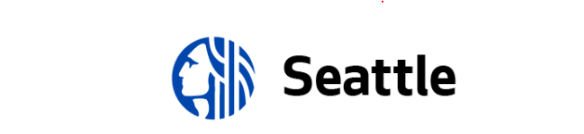

In [1]:
# add notebook summary
import jyquickhelper as jqh
from jyquickhelper import add_notebook_menu
add_notebook_menu(menu_id='OCDS_P4', raw=False, format='html',
                  header="Predict Buildings Energy Use - Modelisation of SiteEnergyUseWN(kBtu)", first_level=1, last_level=5,
                  keep_item=None)

# 1 - Import librairies & packages

In [2]:
# data transformation
import numpy as np
import pandas as pd

# serialization
import pickle

# data pre-processing
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, StratifiedKFold, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

# configure transformers to output pandas DataFrames
from sklearn import set_config
set_config(transform_output="pandas")

# maths & stats
import random

# visualisation
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import seaborn as sns

# dummy model
from sklearn.dummy import DummyRegressor

# linear regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# nearest-neighbors regression model
from sklearn.neighbors import KNeighborsRegressor

# support vector model
from sklearn.svm import SVR

# ensemble learning models
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb

# model performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from timeit import default_timer as timer

# feature importance analysis
import shap
# shap.initjs()

# set dataframe display options
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)

# remove scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# disable convergence warnings after checking
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# 2 - Load data

In [3]:
# initialise random state for all models and transformers
rs_list = [8, 13, 42]
rs = rs_list[random.randrange(len(rs_list))]
print("Random state =", rs)

Random state = 42


In [4]:
# load most highly correlated columns to use for iterative imputation of EnergyStarScore
with open('ess_max_corrs.pkl', 'rb') as f:
    ess_max_corrs = pickle.load(f)

n_features = len(ess_max_corrs)   
    
print(n_features, "features are more strongly correlated to the Energy Star Score : ", ess_max_corrs)

4 features are more strongly correlated to the Energy Star Score :  ['NumberofFloors', 'PropertyGFABuilding(s)', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']


In [5]:
data_all = pd.read_csv('clean_data_all.csv')
# data_all.info()

In [6]:
data_all['OSEBuildingID'] = data_all['OSEBuildingID'].astype('category')
data_all['PrimaryPropertyType'] = data_all['PrimaryPropertyType'].astype('category')
data_all['Neighborhood'] = data_all['Neighborhood'].astype('category')
data_all['SiteEnergyUseWN(kBtu)_bins'] = data_all['SiteEnergyUseWN(kBtu)_bins'].astype('category')
data_all['TotalGHGEmissions_bins'] = data_all['TotalGHGEmissions_bins'].astype('category')

# 3 - Prepare features & target variable

## 3.1 - Without EnergyStarScore

In [7]:
X_no_ess = data_all.drop(labels=['OSEBuildingID', 'PrimaryPropertyType', 'Neighborhood', 'ENERGYSTARScore', 
                                 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'TotalGHGEmissions_bins', 'UsesSteam',
                                 'UsesElectricity', 'UsesGas'], axis=1).copy()
y_no_ess = data_all['SiteEnergyUseWN(kBtu)']
print(X_no_ess.shape)
X_no_ess.head(1)

(1383, 35)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SiteEnergyUseWN(kBtu)_bins,SteamUse_%,Electricity_%,NaturalGas_%
0,47.61220,-122.33799,1.00000,12,0,88434,89,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,high,0.27730,0.54606,0.17664


## 3.2 - With EnergyStarScore

In [8]:
X_w_ess = data_all.drop(labels=['OSEBuildingID', 'PrimaryPropertyType', 'Neighborhood', 'SiteEnergyUseWN(kBtu)', 
                                'TotalGHGEmissions','TotalGHGEmissions_bins', 'UsesSteam', 'UsesElectricity',
                                'UsesGas'], axis=1).copy()
y_w_ess = data_all['SiteEnergyUseWN(kBtu)']
print(X_w_ess.shape)
X_w_ess.head(1)

(1383, 36)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SiteEnergyUseWN(kBtu)_bins,SteamUse_%,Electricity_%,NaturalGas_%
0,47.61220,-122.33799,1.00000,12,0,88434,60.00000,89,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,high,0.27730,0.54606,0.17664


# 4 - Split data into training and testing sets

## 4.1 - Without EnergyStarScore

In [9]:
# split into train (70%) and temp (30%) sets
X_train_no_ess_bins, X_temp_no_ess_bins, y_train_no_ess, y_temp_no_ess = train_test_split(X_no_ess, y_no_ess, test_size=0.3,
                                                                                random_state=rs, shuffle=True,
                                                                                stratify=X_no_ess['SiteEnergyUseWN(kBtu)_bins'])

In [10]:
# further split temp set into testing and validation sets
X_test_no_ess_bins, X_val_no_ess_bins, y_test_no_ess, y_val_no_ess = train_test_split(X_temp_no_ess_bins, y_temp_no_ess,
                                                                                          test_size=0.5, random_state=rs,
                                                                                          shuffle=True, 
                                                                                          stratify=X_temp_no_ess_bins['SiteEnergyUseWN(kBtu)_bins'])

In [11]:
X_train_no_ess = X_train_no_ess_bins.drop(labels=['SiteEnergyUseWN(kBtu)_bins'], axis=1)
X_test_no_ess = X_test_no_ess_bins.drop(labels=['SiteEnergyUseWN(kBtu)_bins'], axis=1)
X_val_no_ess = X_val_no_ess_bins.drop(labels=['SiteEnergyUseWN(kBtu)_bins'], axis=1)

In [12]:
print(X_train_no_ess.shape)
X_train_no_ess.head(1)

(968, 34)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%
1210,47.67819,-122.32310,1.00000,4,0,56896,51,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.71654,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.71119,0.28881


In [13]:
print(X_test_no_ess.shape)
X_test_no_ess.head(1)

(207, 34)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%
1274,47.61556,-122.32048,1.00000,2,0,27938,91,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.49814,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.47205,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.99694,0.00306


In [14]:
print(X_val_no_ess.shape)
X_val_no_ess.head(1)

(208, 34)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%
1268,47.61340,-122.32035,1.00000,2,0,22320,109,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.65485,0.34515


## 4.2 - With EnergyStarScore

In [15]:
# split into train (70%) and temp (30%) sets
X_train_w_ess_bins, X_temp_w_ess_bins, y_train_w_ess, y_temp_w_ess = train_test_split(X_w_ess, y_w_ess, test_size=0.3,
                                                                                random_state=rs, shuffle=True,
                                                                                stratify=X_w_ess['SiteEnergyUseWN(kBtu)_bins'])

In [16]:
# further split temp set into testing and validation sets
X_test_w_ess_bins, X_val_w_ess_bins, y_test_w_ess, y_val_w_ess = train_test_split(X_temp_w_ess_bins, y_temp_w_ess, test_size=0.5,
                                                                                random_state=rs, shuffle=True,
                                                                                stratify=X_temp_w_ess_bins['SiteEnergyUseWN(kBtu)_bins'])

In [17]:
X_train_w_ess = X_train_w_ess_bins.drop(labels=['SiteEnergyUseWN(kBtu)_bins'], axis=1)
X_test_w_ess = X_test_w_ess_bins.drop(labels=['SiteEnergyUseWN(kBtu)_bins'], axis=1)
X_val_w_ess = X_val_w_ess_bins.drop(labels=['SiteEnergyUseWN(kBtu)_bins'], axis=1)

In [18]:
print(X_train_w_ess.shape)
X_train_w_ess.head(1)

(968, 35)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%
1210,47.67819,-122.32310,1.00000,4,0,56896,96.00000,51,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.71654,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.71119,0.28881


In [19]:
print(X_test_w_ess.shape)
X_test_w_ess.head(1)

(207, 35)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%
1274,47.61556,-122.32048,1.00000,2,0,27938,97.00000,91,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.49814,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.47205,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.99694,0.00306


In [20]:
print(X_val_w_ess.shape)
X_val_w_ess.head(1)

(208, 35)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%
1268,47.61340,-122.32035,1.00000,2,0,22320,NaN,109,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.65485,0.34515


### 4.2.1 - Imputation on training set

In [21]:
# use iterative imputer to fill NaNs in EnergyStarScore column - set min to 0 and max to 100 as per methodology available at :
# https://www.energystar.gov/buildings/benchmark/understand-metrics/how-score-calculated
energy_star = IterativeImputer(missing_values=np.nan, max_iter=10, tol=0.001, n_nearest_features=n_features,
                                 initial_strategy='mean', imputation_order='ascending', min_value=1, max_value=100,
                                 skip_complete=False,  verbose=1, random_state=rs, add_indicator=False)

In [22]:
X_1 = X_train_w_ess.select_dtypes(include='number')
imputed_1 = energy_star.fit_transform(X_1)
X_train_w_ess_ii = pd.DataFrame(imputed_1, columns=X_1.columns).reset_index(drop=True)
X_2 = X_train_w_ess.select_dtypes(exclude='number').reset_index(drop=True)
X_train_w_ess_imputed = X_2.join(X_train_w_ess_ii)
X_train_w_ess_imputed['ENERGYSTARScore'] = round(X_train_w_ess_imputed['ENERGYSTARScore'],0).astype(int, errors='ignore')
print(X_train_w_ess_imputed.shape)
print(X_train_w_ess_imputed.isna().sum().sum(), 'nulls in result dataframe.')
X_train_w_ess_imputed.sample(5)

[IterativeImputer] Completing matrix with shape (968, 35)
[IterativeImputer] Change: 28.82691386528863, scaled tolerance: 1765.97 
[IterativeImputer] Early stopping criterion reached.
(968, 35)
0 nulls in result dataframe.


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%
940,47.63927,-122.40320,1.00000,2.00000,0.00000,22612.00000,87,69.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.21457,0.78543
293,47.60582,-122.33464,1.00000,13.00000,74481.00000,219322.00000,25,18.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.49520,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
414,47.69400,-122.28967,1.00000,2.00000,0.00000,43645.00000,71,67.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.84775,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.25262,0.74738
139,47.63376,-122.33968,1.00000,7.00000,0.00000,94002.00000,70,46.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.99897,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
962,47.66517,-122.31037,1.00000,3.00000,0.00000,41013.00000,62,89.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.05632,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.78263,0.00000,0.00000,0.40054,0.59946


### 4.2.2 - Imputation on testing set

In [23]:
X_3 = X_test_w_ess.select_dtypes(include='number')
imputed_3 = energy_star.transform(X_3)
X_test_w_ess_ii = pd.DataFrame(imputed_3, columns=X_3.columns).reset_index(drop=True)
X_4 = X_test_w_ess.select_dtypes(exclude='number').reset_index(drop=True)
X_test_w_ess_imputed = X_4.join(X_test_w_ess_ii)
X_test_w_ess_imputed['ENERGYSTARScore'] = round(X_test_w_ess_imputed['ENERGYSTARScore'],0).astype(int, errors='ignore')
print(X_test_w_ess_imputed.shape)
print(X_test_w_ess_imputed.isna().sum().sum(), 'nulls in result dataframe.')
X_test_w_ess_imputed.sample(5)

[IterativeImputer] Completing matrix with shape (207, 35)
(207, 35)
0 nulls in result dataframe.


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%
203,47.62902,-122.33173,1.00000,2.00000,0.00000,26519.00000,62,38.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.48746,0.00000,0.00000,0.00000,0.00000,0.00000,0.51254,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.58394,0.41606
137,47.59856,-122.33248,1.00000,2.00000,0.00000,36630.00000,90,86.00000,0.00000,0.00000,0.00000,0.30030,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.60060,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
196,47.61744,-122.30514,1.00000,3.00000,0.00000,31357.00000,55,17.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.15945,0.00000,0.81322,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.90310,0.09690
158,47.67923,-122.31715,1.00000,3.00000,0.00000,22522.00000,62,69.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.24330,0.75670
66,47.70941,-122.31707,1.00000,1.00000,0.00000,44755.00000,56,20.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.04967,0.00000,0.00000,0.00000,0.51415,0.48585


### 4.2.3 - Imputation on validation set

In [24]:
X_5 = X_val_w_ess.select_dtypes(include='number')
imputed_5 = energy_star.transform(X_5)
X_val_w_ess_ii = pd.DataFrame(imputed_5, columns=X_5.columns).reset_index(drop=True)
X_6 = X_val_w_ess.select_dtypes(exclude='number').reset_index(drop=True)
X_val_w_ess_imputed = X_6.join(X_val_w_ess_ii)
X_val_w_ess_imputed['ENERGYSTARScore'] = round(X_val_w_ess_imputed['ENERGYSTARScore'],0).astype(int, errors='ignore')
print(X_val_w_ess_imputed.shape)
print(X_val_w_ess_imputed.isna().sum().sum(), 'nulls in result dataframe.')
X_val_w_ess_imputed.sample(5)

[IterativeImputer] Completing matrix with shape (208, 35)
(208, 35)
0 nulls in result dataframe.


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%
22,47.66894,-122.38242,1.00000,2.00000,0.00000,21528.00000,62,92.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.68396,0.31604
153,47.64909,-122.37788,1.00000,1.00000,0.00000,25842.00000,35,55.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00561,0.00000,0.00000,0.00000,0.54670,0.45330
137,47.62333,-122.32960,1.00000,5.00000,70067.00000,106465.00000,60,15.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.58626,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
162,47.61598,-122.33448,1.00000,11.00000,68432.00000,230638.00000,69,12.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.83592,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.46913,0.53087
69,47.56680,-122.32149,1.00000,1.00000,0.00000,25520.00000,100,59.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.98746,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.35718,0.64282


# 5 - Preprocessing

## 5.1 - For Linear models, K-nearest Neighbors and Support Vector Regression

In [25]:
# specify transformations to apply by column type
num_transfo_lin = Pipeline(steps=[('scaler', PowerTransformer(method='yeo-johnson',standardize=True, copy=True))])
num_transfo_ens = Pipeline(steps=[('scaler', StandardScaler())])

### 5.1.1 - Without Energy Star Score

In [26]:
# split numerical and categorical columns for data without EnergyStarScore and list column names
num_X_no_ess = X_train_no_ess.select_dtypes(include='number').columns.tolist()
preproc_lin_no_ess = ColumnTransformer(transformers=[('num', num_transfo_lin, num_X_no_ess)])

### 5.1.2 - With Energy Star Score

In [27]:
# split numerical and categorical columns for data with EnergyStarScore and list column names
num_X_w_ess = X_train_w_ess_imputed.select_dtypes(include='number').columns.tolist()
preproc_lin_w_ess = ColumnTransformer(transformers=[('num', num_transfo_lin, num_X_w_ess)])

## 5.2 - For Ensemble Learning Models

**StandardScaler is not generally required with tree-based and other ensemble learning models, although it can in some very specific cases improve the performance of the model. As this is not the case here, this pre-precessing step has been removed from the pipeline.**

# 6 - Modelisation

## 6.1 - Without EnergyStarScore

In [28]:
# initialise models
models = [
    ('Linear Regression', LinearRegression()),
    ('ElasticNet', ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('SVR', SVR()),
    ('Random Forest Regression', RandomForestRegressor()),
    ('Gradient Boosting Regression', GradientBoostingRegressor()),
]

# create list of ensemble models
ens_models = ['Random Forest Regression', 'Gradient Boosting Regression']

# define hyperparameter grids
param_grids = [
    # for Linear Regression
    {'model__fit_intercept': [True, False], 'model__copy_X' : [True]}, 
    # for ElasticNet Regression
    {'model__alpha' : [0.001, 0.01, 0.1, 1, 10], 'model__random_state': [rs], 'model__copy_X' : [True]},
    # for KNN Regression
    {'model__n_neighbors': [5, 10, 15], 'model__weights' : ['uniform', 'distance']}, 
    # for Support Vector Regression
    {'model__kernel' : ['poly'], 'model__degree' : [2,3], 'model__gamma' : [1, 10],
     'model__C' : [0.1, 1], 'model__epsilon' : [0.1, 0.5]},
    # for Random Forest Regression
    {'model__n_estimators': [100, 200], 'model__random_state' : [rs], 'model__max_depth' : [None]}, 
    # for Gradient Boosting Regression
    {'model__learning_rate' : [0.5, 0.25, 0.1], 'model__n_estimators' : [100, 200], 
    'model__random_state' : [rs]}     
]

In [29]:
# fit models using GridSearchCV

# initialize empty list to store models evaluation metrics
model_metrics_no_ess = []

# iterate over models and respective parameter grid
for (name, model), param_grid in zip(models, param_grids):
    # create pipeline with relevant preprocessor and model
    if name in ens_models:
        pipe = Pipeline(steps=[('model', model)])
    else:
        pipe = Pipeline(steps=[('preprocessor', preproc_lin_no_ess), ('model', model)])
    
    # k_values = np.arange(2,10,1)
    # k_values = [5, 9, 10]
    k_values = [10] # on all fits, k=10 consistently gave the best model, so we limit iterations on k to save on fit time
    
    for k in k_values:
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=rs)
        spl = skf.split(X_train_no_ess, X_train_no_ess_bins['SiteEnergyUseWN(kBtu)_bins'])
        
        # Perform GridSearchCV on the pipeline with the current hyperparameter grid
        grid_search = GridSearchCV(pipe, param_grid, cv=spl, scoring='r2', refit=True, error_score='raise', verbose=False)
    
        # Fit the GridSearchCV object on the training data
        train_start = timer()
        grid_search.fit(X_train_no_ess, y_train_no_ess.values)
        train_end = timer()
        train_time = train_end - train_start
        
        # Get the best hyperparameters and best training score
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
           
        # evaluate model on validation set & get score
        val_start = timer()
        val_score = grid_search.score(X_val_no_ess, y_val_no_ess) # uses score defined by scoring or best_estimator_.score
        y_pred_no_ess = grid_search.predict(X_val_no_ess)
        val_end = timer()
        val_time = val_end - val_start
        
        # Extract coefficients from the best estimator
        best_model = grid_search.best_estimator_
                 
    # append results to results list
    model_metrics_no_ess.append({
        'Model': name,
        'Training set':'X_train_no_ess',
        'Best parameters': best_params,
        'Train R2': best_score,  
        'Train fit time': train_time,        
        'Val R2': val_score, 
        'Val MAE' : mean_absolute_error(y_val_no_ess, y_pred_no_ess),
        'Strat. K-Fold' : skf        
    })

C:\Users\PC\anaconda3\envs\shap_env\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [30]:
# store model metrics & coefs in dataframes
model_no_ess_compare = pd.DataFrame(model_metrics_no_ess)

# display dataframe
model_no_ess_compare

,Model,Training set,Best parameters,Train R2,Train fit time,Val R2,Val MAE,Strat. K-Fold
0,Linear Regression,X_train_no_ess,"{'model__copy_X': True, 'model__fit_intercept': True}",0.15723,5.11510,0.22969,8343228.59183,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
1,ElasticNet,X_train_no_ess,"{'model__alpha': 1, 'model__copy_X': True, 'model__random_state': 42}",0.28758,6.49200,0.22139,6682449.48512,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
2,KNN,X_train_no_ess,"{'model__n_neighbors': 15, 'model__weights': 'distance'}",0.28464,10.84146,0.50806,4764916.84362,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
3,SVR,X_train_no_ess,"{'model__C': 1, 'model__degree': 3, 'model__epsilon': 0.5, 'model__gamma': 10, 'model__kernel': 'poly'}",0.39187,29.85449,0.19939,5558838.00879,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
4,Random Forest Regression,X_train_no_ess,"{'model__max_depth': None, 'model__n_estimators': 200, 'model__random_state': 42}",0.58454,37.22161,0.77205,3686620.32705,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
5,Gradient Boosting Regression,X_train_no_ess,"{'model__learning_rate': 0.1, 'model__n_estimators': 100, 'model__random_state': 42}",0.53390,32.62086,0.73796,4054347.41313,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"


In [31]:
# export dataframes to file
model_no_ess_compare.to_csv('SEU_model_no_ess_compare.csv', index=False)

## 6.2 - With EnergyStarScore

In [32]:
# fit models using GridSearchCV

# initialize empty list to store model evaluation metrics
model_metrics_w_ess = []

# iterate over models and respective parameter grid
for (name, model), param_grid in zip(models, param_grids):
    # create pipeline with relevant preprocessor and model
    if name in ens_models:
        pipe = Pipeline(steps=[('model', model)])
    else:
        pipe = Pipeline(steps=[('preprocessor', preproc_lin_w_ess), ('model', model)])
    
    # k_values = np.arange(2,10,1)
    # k_values = [5, 9, 10]
    k_values = [10] # on all fits, k=10 consistently gave the best model, so we limit iterations on k to save on fit time
    
    for k in k_values:
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=rs)
        spl = skf.split(X_train_w_ess_imputed, X_train_w_ess_bins['SiteEnergyUseWN(kBtu)_bins'])
        
        # Perform GridSearchCV on the pipeline with the current hyperparameter grid
        grid_search = GridSearchCV(pipe, param_grid, cv=spl, scoring='r2', refit=True, error_score='raise', verbose=False)
    
        # Fit the GridSearchCV object on the training data
        train_start = timer()
        grid_search.fit(X_train_w_ess_imputed, y_train_w_ess.values)
        train_end = timer()
        train_time = train_end - train_start
        
        # get best hyperparameters & best training score
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
          
        # evaluate model on validation set & get score
        val_start = timer()
        val_score = grid_search.score(X_val_w_ess_imputed, y_val_w_ess)
        y_pred_w_ess = grid_search.predict(X_val_w_ess_imputed)
        val_end = timer()
        val_time = val_end - val_start
        
        # extract coefficients from best estimator
        best_model = grid_search.best_estimator_
    
    # append results to results list
    model_metrics_w_ess.append({
        'Model': name,
        'Training set':'X_train_w_ess',
        'Best parameters': best_params,
        'Train R2': best_score,
        'Train fit time': train_time,        
        'Val R2': val_score,
        'Val MAE' : mean_absolute_error(y_val_w_ess, y_pred_w_ess),        
        'Strat. K-Fold' : skf       
    })

In [33]:
# store model metrics in dataframe
model_w_ess_compare = pd.DataFrame(model_metrics_w_ess)

# display dataframe
model_w_ess_compare

,Model,Training set,Best parameters,Train R2,Train fit time,Val R2,Val MAE,Strat. K-Fold
0,Linear Regression,X_train_w_ess,"{'model__copy_X': True, 'model__fit_intercept': True}",0.16732,2.20698,0.24235,8283946.32558,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
1,ElasticNet,X_train_w_ess,"{'model__alpha': 1, 'model__copy_X': True, 'model__random_state': 42}",0.29437,5.54495,0.22959,6636985.49279,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
2,KNN,X_train_w_ess,"{'model__n_neighbors': 15, 'model__weights': 'distance'}",0.27832,6.85814,0.45840,4748229.26351,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
3,SVR,X_train_w_ess,"{'model__C': 1, 'model__degree': 3, 'model__epsilon': 0.5, 'model__gamma': 10, 'model__kernel': 'poly'}",0.39414,28.00214,0.06508,5809382.73292,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
4,Random Forest Regression,X_train_w_ess,"{'model__max_depth': None, 'model__n_estimators': 200, 'model__random_state': 42}",0.60020,40.64560,0.79930,3443620.87142,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
5,Gradient Boosting Regression,X_train_w_ess,"{'model__learning_rate': 0.1, 'model__n_estimators': 200, 'model__random_state': 42}",0.57515,35.07362,0.77347,3590709.12034,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"


In [34]:
# export dataframe to file
model_w_ess_compare.to_csv('SEU_model_w_ess_compare.csv', index=False)

## 6.3 - Best model choice & evaluation

### 6.3.1 - Determine best model based on validation set results

In [35]:
# find best model & best features set
best_model_no_ess = model_no_ess_compare.loc[model_no_ess_compare['Val R2'] == model_no_ess_compare['Val R2'].max()]
best_model_w_ess = model_w_ess_compare.loc[model_w_ess_compare['Val R2'] == model_w_ess_compare['Val R2'].max()]
best_models = pd.concat([best_model_no_ess, best_model_w_ess])
best_models

,Model,Training set,Best parameters,Train R2,Train fit time,Val R2,Val MAE,Strat. K-Fold
4,Random Forest Regression,X_train_no_ess,"{'model__max_depth': None, 'model__n_estimators': 200, 'model__random_state': 42}",0.58454,37.22161,0.77205,3686620.32705,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"
4,Random Forest Regression,X_train_w_ess,"{'model__max_depth': None, 'model__n_estimators': 200, 'model__random_state': 42}",0.60020,40.64560,0.79930,3443620.87142,"StratifiedKFold(n_splits=10, random_state=42, shuffle=True)"


**The inclusion of the Energy Star Score only very slightly improves the training and validation R2. We will therefore leave it out of the features for the final model.**

In [36]:
best_model = best_models.loc[best_models['Training set'] == 'X_train_no_ess']['Model'][4]
print('Best model :\n', best_model)

best_params = best_models.loc[best_models['Training set'] == 'X_train_no_ess']['Best parameters'][4]
print('Best parameters :\n', best_params)

Best model :
 Random Forest Regression
Best parameters :
 {'model__max_depth': None, 'model__n_estimators': 200, 'model__random_state': 42}


In [37]:
# import parameters from modelisation results
final_params = {
    key.replace('model__', ''): value
    for key, value in best_params.items()
    if isinstance(key, str)
}

final_params

{'max_depth': None, 'n_estimators': 200, 'random_state': 42}

### 6.3.2 - Retrain model on entire dataset (train + val)

#### 6.3.2.1 - Without Energy Star Score

**- Create new training set from original training set and validation set :**

In [38]:
X_train = pd.concat([X_train_no_ess, X_val_no_ess])
print(X_train.shape)
X_train.sample(5)

(1176, 34)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%
744,47.62296,-122.33620,1.00000,5,0,508160,7,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.64911,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.02331,0.00000,0.77443,0.22557
466,47.60366,-122.33328,1.00000,3,0,52298,95,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.96084,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
77,47.59809,-122.32283,1.00000,4,13820,59000,106,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.79648,0.00000,0.65242,0.34758
1044,47.52549,-122.33064,1.00000,1,0,48020,37,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.99542,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.61111,0.38889
942,47.56121,-122.33872,1.00000,1,0,26094,63,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000


In [39]:
y_train = pd.concat([y_train_no_ess, y_val_no_ess])
print(y_train.shape)
y_train.sample(5)

(1176,)


675    2498335.25000
869    1286817.37500
669   10234721.00000
260    6917478.50000
106   10168523.00000
Name: SiteEnergyUseWN(kBtu), dtype: float64

In [40]:
X_test = X_test_no_ess
print(X_test.shape)
X_test.sample(5)

(207, 34)


,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%
1343,47.58430,-122.32229,1.00000,2,0,56988,2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.43027,0.00000,0.50854,0.49146
1215,47.59986,-122.32987,1.00000,4,0,43484,110,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.60749,0.17333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.21918,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
269,47.65821,-122.31831,1.00000,4,88405,108344,28,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.55067,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.61067,0.38933
1295,47.59706,-122.32813,1.00000,11,0,68452,16,0.09915,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.90085,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
208,47.61022,-122.33745,1.00000,30,134662,620338,31,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.85177,0.00000,0.00000,0.00000,0.00000,0.00000,0.01778,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00995,0.82717,0.16288


In [41]:
y_test = y_test_no_ess
print(y_test.shape)
y_test.sample(5)

(207,)


1231   5652231.00000
486    4843056.00000
179    5569686.00000
705    1931830.75000
1222   1377497.25000
Name: SiteEnergyUseWN(kBtu), dtype: float64

**- Apply same pre-processing step as in ensemble learning models pipeline:**
**- Train model on training + validation set using best hyperparameters and evaluate performance on testing set:**

In [42]:
final_model = RandomForestRegressor(**final_params)
final_pipe = Pipeline(steps=[('model', final_model)])

In [43]:
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)
print('Test R2 : ', r2_score(y_test, y_pred))
print('\nTest MAE :', mean_absolute_error(y_test, y_pred))

Test R2 :  0.6889981103218434

Test MAE : 3084918.721871788


In [44]:
y_train_pred = final_pipe.predict(X_train)
preds = pd.DataFrame(np.concatenate((y_train_pred, y_pred), axis=0), columns=['SiteEnergyUseWN(kBtu)_pred'])
print(len(y_train_pred))
print(len(y_pred))

1176
207


#### 6.3.2.2 - With Energy Star Score

**This data will be used for graphical representation purposes only.**

In [45]:
final_params_ess = final_params

In [46]:
X_train_ess = pd.concat([X_train_w_ess_imputed, X_val_w_ess_imputed])
X_train_ess.head(1)

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%
0,47.67819,-122.32310,1.00000,4.00000,0.00000,56896.00000,96,51.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.71654,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.71119,0.28881


In [47]:
y_train_ess = pd.concat([y_train_w_ess, y_val_w_ess])

In [48]:
X_test_ess = X_test_w_ess_imputed
X_test_ess.head(1)

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%
0,47.61556,-122.32048,1.00000,2.00000,0.00000,27938.00000,97,91.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.49814,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.47205,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.99694,0.00306


In [49]:
y_test_ess = y_test_w_ess
final_model_w_ess = RandomForestRegressor(**final_params_ess)
final_model_w_ess.fit(X_train_ess, y_train_ess)
y_pred_ess = final_model_w_ess.predict(X_test_ess)
print('Test R2 : ', r2_score(y_test_ess, y_pred_ess))
print('\nTest MAE :', mean_absolute_error(y_test_ess, y_pred_ess))

Test R2 :  0.699248476413816

Test MAE : 2934380.6128453654


## 6.4 - Full predictions and export

### 6.4.1 - Prediction of SiteEnergyUseWN(kBtu) on whole dataset without Energy Star Score

In [50]:
X = pd.concat([X_train_w_ess_imputed, X_val_w_ess_imputed, X_test_w_ess_imputed])
y = pd.concat(([y_train_w_ess, y_val_w_ess,  y_test_w_ess]))

In [51]:
model_final = RandomForestRegressor(**final_params)
model_final.fit(X, y)
y_pred_final = model_final.predict(X)
X['SiteEnergyUseWN(kBtu)'] = y
X['SiteEnergyUseWN(kBtu)_pred'] = y_pred_final
X.sample(5)

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu),SiteEnergyUseWN(kBtu)_pred
382,47.59856,-122.33379,1.00000,6.00000,0.00000,73260.00000,82,109.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.87184,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,7589347.50000,3208114.04312
444,47.61770,-122.33060,1.00000,11.00000,195621.00000,185760.00000,94,16.00000,0.00000,0.00000,0.00000,0.00000,0.09907,0.00000,0.00000,0.00000,0.00000,0.00000,0.43052,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.99038,0.00962,5034942.50000,10981730.33500
680,47.60707,-122.32880,1.00000,9.00000,101342.00000,201560.00000,58,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.66479,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.95962,0.04038,1214408.75000,15972291.92000
226,47.62131,-122.33814,1.00000,6.00000,109905.00000,193198.00000,97,10.00000,0.01984,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.58933,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.95053,0.04947,21156670.00000,8688173.69750
430,47.70799,-122.30185,1.00000,4.00000,0.00000,80360.00000,96,29.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.63704,0.36296,5459973.50000,1399781.57516


### 6.4.2 - Export dataset

In [52]:
data_all_ter = data_all.copy()
data_all_ter['SiteEnergyUseWN(kBtu)_pred'] = preds
data_all_ter[['SiteEnergyUseWN(kBtu)', 'SiteEnergyUseWN(kBtu)_pred']].sample(10)

,SiteEnergyUseWN(kBtu),SiteEnergyUseWN(kBtu)_pred
426,1015060.18800,3070632.41312
615,3269279.75000,15092290.81188
1229,13584036.00000,4521376.57891
234,18471858.00000,1558754.59781
852,602201.62500,7660751.62281
125,26122018.00000,4136741.28000
366,2472120.00000,6019160.93562
185,14072349.00000,8318578.22375
169,4426136.00000,1210992.44721
1140,823716.87500,3606632.14422


In [53]:
data_all_ter.shape

(1383, 46)

In [54]:
# export dataframe to csv
data_all_ter.to_csv('data_all_ter.csv', index=False)

### 6.4.3 - Prediction of SiteEnergyUseWN(kBtu) on whole dataset with Energy Star Score

In [55]:
X_ess = pd.concat([X_train_w_ess_imputed, X_val_w_ess_imputed, X_test_w_ess_imputed])
y_ess = data_all['SiteEnergyUseWN(kBtu)']

In [56]:
model_final_ess = RandomForestRegressor(**final_params_ess)
model_final_ess.fit(X_ess, y_ess)
y_pred_ess_final = model_final_ess.predict(X_ess)
X_ess['SiteEnergyUseWN(kBtu)'] = y_ess
X_ess['SiteEnergyUseWN(kBtu)_pred_ess'] = y_pred_ess_final
X_ess.sample(5)

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,BuildingAge,Bank Branch,College/University,Data Center,Distribution Center,Fitness Center/Health Club/Gym,Hotel,K-12 School,Laboratory,Medical Office,Non-Refrigerated Warehouse,Office,Other,Other - Entertainment/Public Assembly,Other - Recreation,Other - Services,Refrigerated Warehouse,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Supermarket/Grocery Store,Worship Facility,Other_aggregated_usage,SteamUse_%,Electricity_%,NaturalGas_%,SiteEnergyUseWN(kBtu),SiteEnergyUseWN(kBtu)_pred_ess
146,47.59693,-122.31124,1.00000,2.00000,0.00000,28296.00000,80,53.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.95063,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,4188308.75000,12641070.93617
628,47.64868,-122.34254,1.00000,5.00000,79284.00000,126842.00000,98,3.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.49456,0.04038,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.80223,0.19777,2654904.25000,6422875.35141
848,47.61952,-122.34462,1.00000,3.00000,0.00000,51552.00000,62,3.00000,0.00000,0.00000,0.01261,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.05040,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,2168833.00000,6447669.18875
667,47.63670,-122.32850,1.00000,3.00000,13540.00000,36959.00000,13,16.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.73188,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.99925,0.00075,7048919.00000,6840832.70342
219,47.62518,-122.35317,1.00000,2.00000,0.00000,30720.00000,62,68.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.03255,0.91536,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.28641,0.71359,14436982.00000,12733686.03875


### 6.4.4 - Graph true vs. predicted values

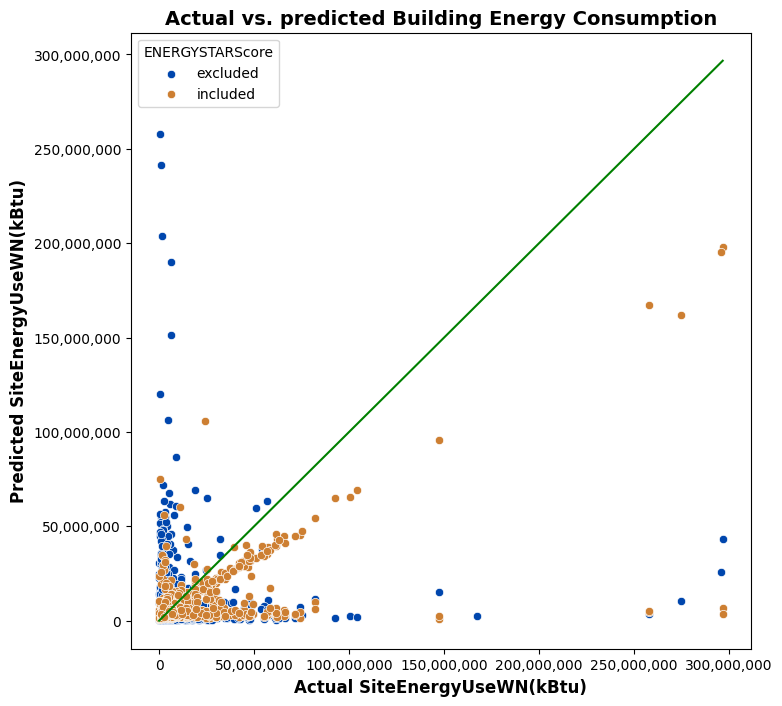

In [57]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=data_all_ter['SiteEnergyUseWN(kBtu)'], y=data_all_ter['SiteEnergyUseWN(kBtu)_pred'], color='#0046AD')
sns.scatterplot(x=X_ess['SiteEnergyUseWN(kBtu)'], y=X_ess['SiteEnergyUseWN(kBtu)_pred_ess'], color='#CD7F32')
plt.legend(title='ENERGYSTARScore', loc='upper left', labels=['excluded', 'included'])
sns.lineplot(x=y, y=y, color='green')
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title("Actual vs. predicted Building Energy Consumption", fontsize=14, fontweight='bold')
plt.xlabel("Actual SiteEnergyUseWN(kBtu)", fontsize=12, fontweight='bold')
plt.ylabel("Predicted SiteEnergyUseWN(kBtu)", fontsize=12, fontweight='bold')
plt.savefig('SiteEnergyUse_ActuVsPred.png')
plt.show()

# 7 - Feature importance analysis

## 7.1 - Global feature importance

In [58]:
shap_values = shap.TreeExplainer(final_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.savefig('SEU_shap_global_bars.png', bbox_inches='tight')
plt.close()

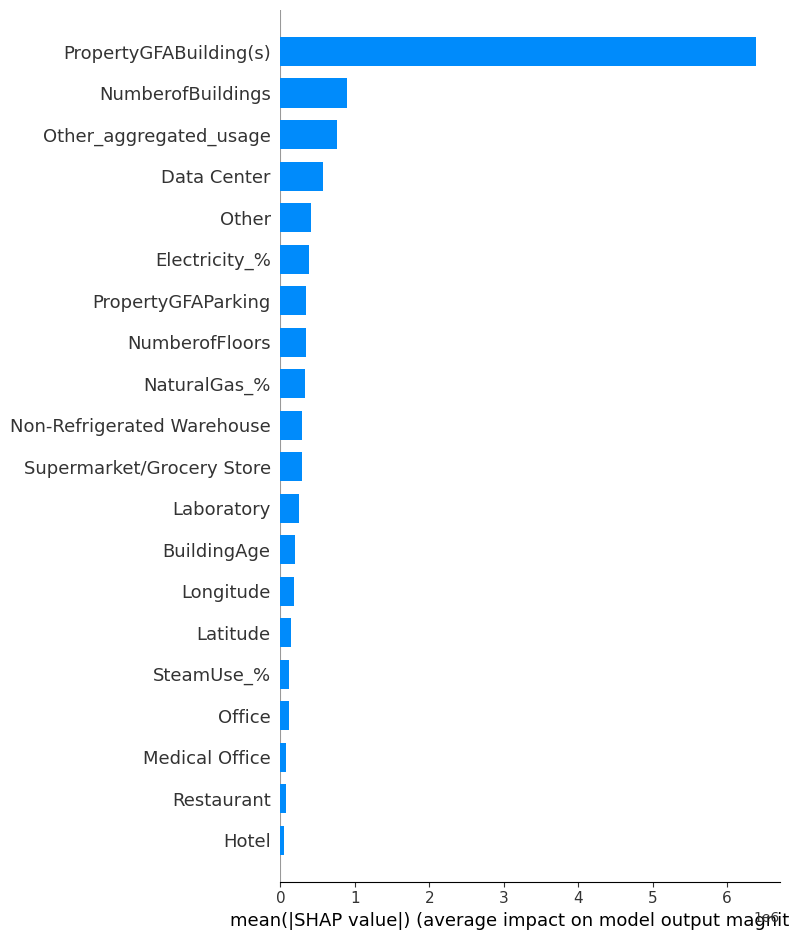

In [59]:
shap.decision_plot(shap.TreeExplainer(final_model).expected_value, shap_values, features = X_train.columns, show=False)
plt.savefig('SEU_shap_global_decision.png', bbox_inches='tight')
plt.close()

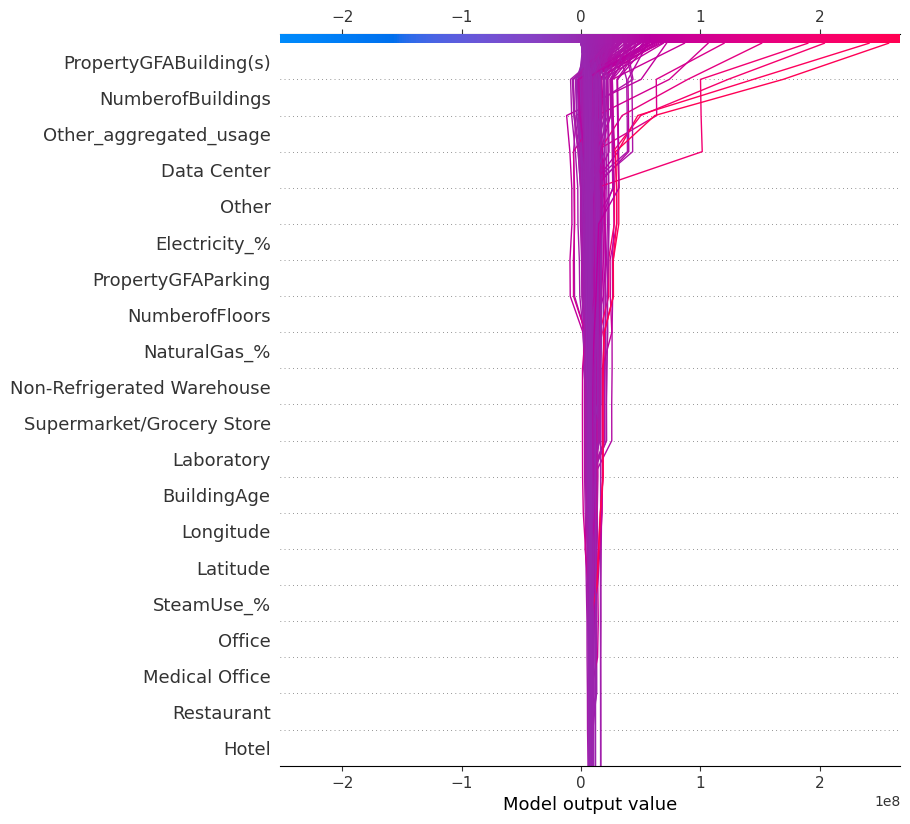

In [60]:
shap.summary_plot(shap_values, X_train, show=False)
plt.savefig('SEU_shap_global_plot.png', bbox_inches='tight')
plt.close()

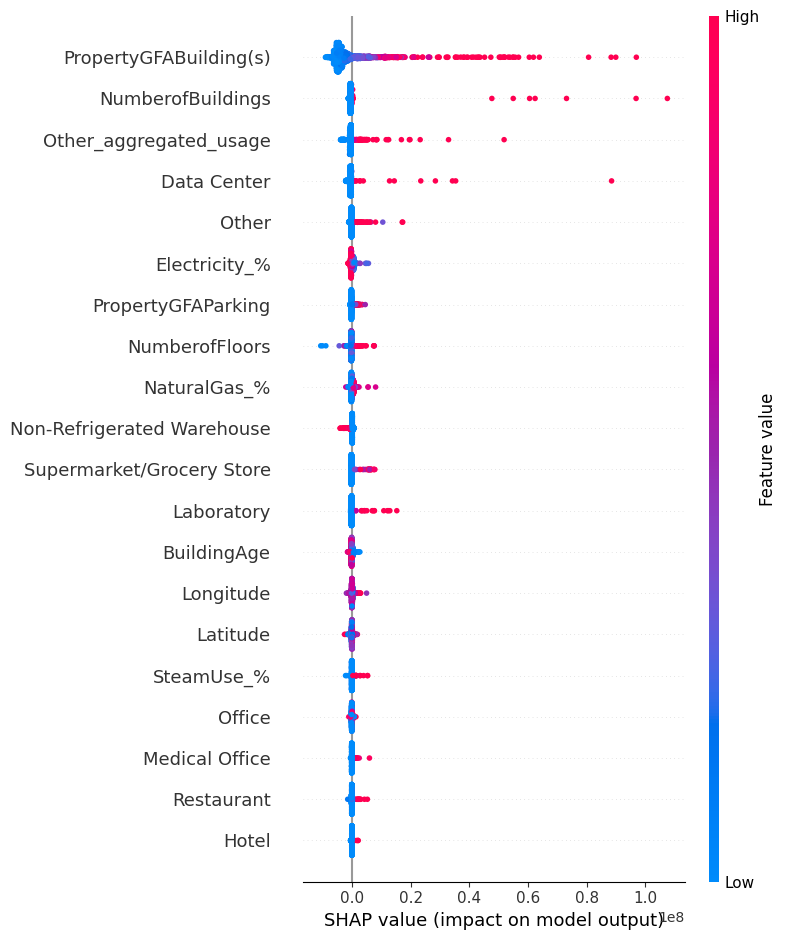

In [61]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)
shap.plots.beeswarm(shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_train), show=False)
plt.savefig('SEU_shap_swarm.png', bbox_inches='tight')
plt.close()

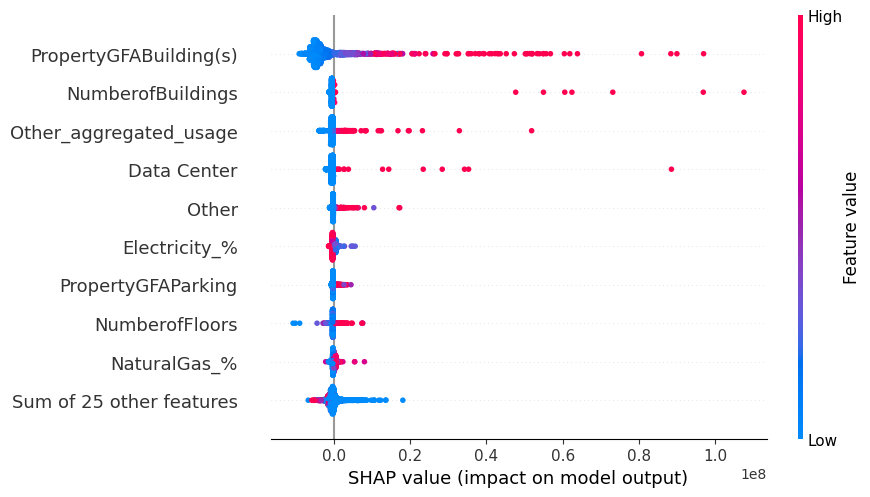

## 7.2 - Local feature importance

In [62]:
bat_num = 42
shap.force_plot(shap.TreeExplainer(final_model).expected_value, shap_values[bat_num], X_train.iloc[bat_num,:], show=False, 
                matplotlib=True, text_rotation=15)
plt.savefig('SEU_shap_local_1.png', bbox_inches='tight')
plt.close()

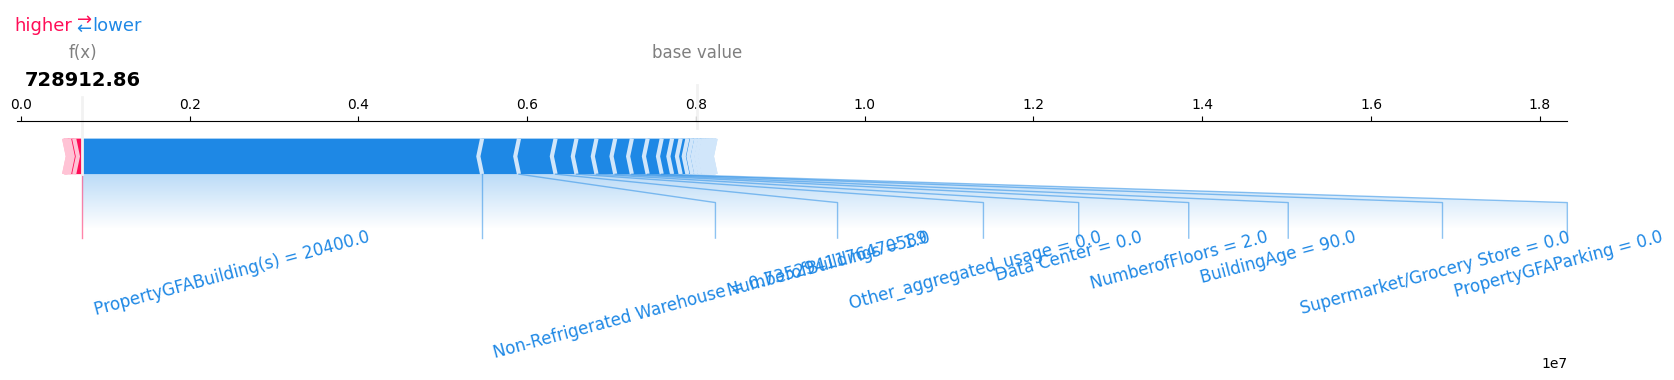

In [63]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)
shap_value_i = shap_values[bat_num]
expected_value = explainer.expected_value
shap.plots.waterfall(shap.Explanation(values=shap_value_i, base_values=expected_value, data=X_train.iloc[bat_num]), show=False)
plt.savefig('SEU_shap_local_2.png', bbox_inches='tight')
plt.close()

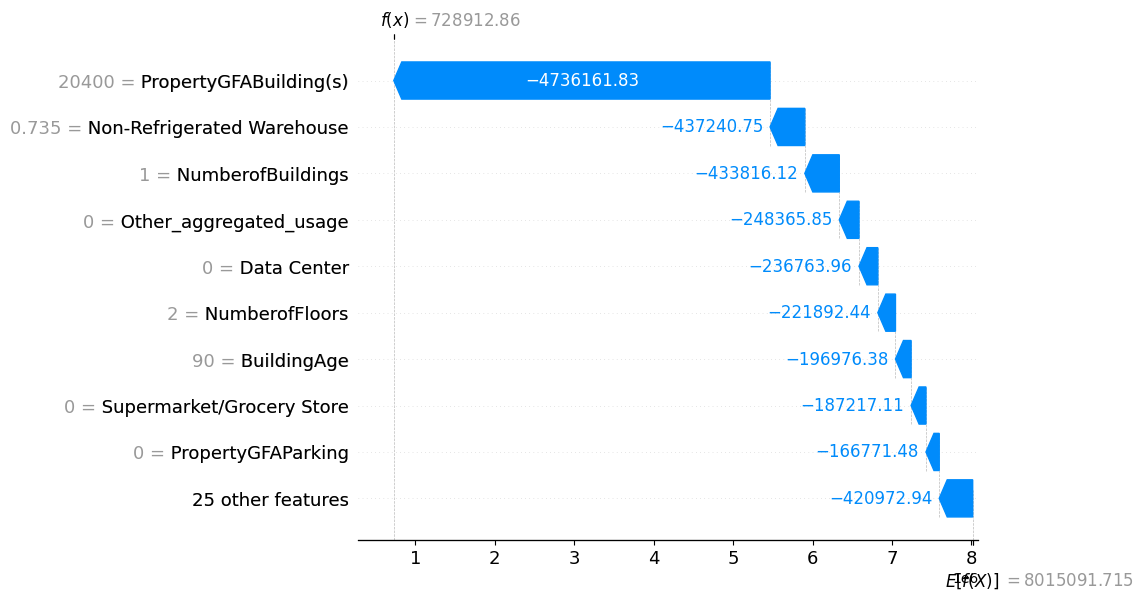